# HW1.1 Cifar10 Classification

>**作業說明**

請**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

請**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

請**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名姓名**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 上述兩個檔案繳交至ee-class。

> **繳交期限**

1. 電子商務智慧技術(IMA0200): 期限至2012/4/2(五) 23:59分

有問題再直接Line助教，我有空就會秒回

## 1. 讀入封包

深度學習一般目前市場上常見的有tensorflow、keras、pytorch。本次Demo使用keras，keras是一個簡單好用的模型訓練工具。能夠幫助初學者省去很多在訓練上的細節，使機器學習更加快速、好上手。

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

## 2. 取得資料集

* 由keras內部method可以線上取得Cifar10的資料集。並且已經自動分離出了訓練用與測試用的資料集。
* x_train是一個包含50000張圖片。
* x_train要預測的是y_train的50000個對應標籤，分別是當前對應圖片的0~9數字。因此共十個class。

In [ ]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("-"*20)
print("x_test shape : ",x_test.shape)
print("y_test shape : ",y_test.shape)

x_train shape :  (50000, 32, 32, 3)
y_train shape :  (50000, 1)
--------------------
x_test shape :  (10000, 32, 32, 3)
y_test shape :  (10000, 1)


* 我們可以實際將這些圖片印出來看看
* Cifar10每個標籤的意義如下

![](https://i.imgur.com/Vz5IsTL.png)

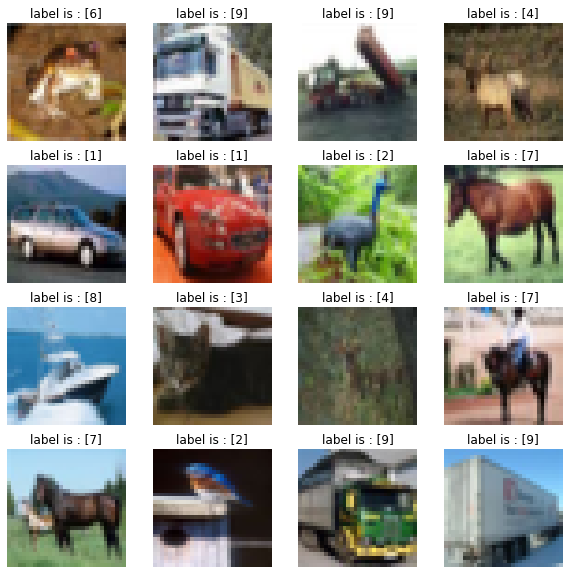

In [ ]:
# 印出來看看
plt.figure(figsize=(10, 10))
for i in range(16):
    img = x_train[i]
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap ='gray')
    plt.title("label is : {}".format(y_train[i]))
    plt.axis("off")

## 3. 資料前處理

* 可以知道一張圖片的維度是(28,28)，但是實際輸入模型的維度是(28,28,1)。灰階圖片少了channel，所以我們要拓展維度 (作為channel)

* 然後我們要把圖片pixel 自 [0,255] --> [0,1] ，讓深度學習在矩陣相乘時不會因為數值相乘太大而很難訓練。

In [ ]:
##########
# todo #
##########

- 然後要把label轉為one-hot。因為我們預期模型訓練是
    - 輸入: (28,28,1) 的圖片
    - 輸出: (10,) 的機率
    
    
- 打個比方:
    - ![](https://i.imgur.com/aCYEeRB.png)
    - 所以我們需要將label轉成one-hot 格式

In [ ]:
train_label = keras.utils.to_categorical(y_train, num_classes)
test_label = keras.utils.to_categorical(y_test, num_classes)

for i in range(10):
    print(y_train[i]," ---> ",train_label[i])

[6]  --->  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[9]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[9]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[4]  --->  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1]  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1]  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[2]  --->  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[7]  --->  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[8]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[3]  --->  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## 4. 建立模型

我們本次建立的模型CNN，由Convolution層與Fully Connection層組成

#### **對Keras來說**

1. 一張圖片通過**Conv**後維度計算: [keras Conv](https://keras.io/api/layers/convolution_layers/convolution2d/)
* 默認stride:(1,1)
* 默認padding = None
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-kernal]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-kernal]}{stride} +1$

> E.g.
>
> input: **(32,28,28,3)**
>
> kernel: 3,padding=0,stride=1,filters=32
> 
> $(28-2*0-3)/1 + 1 = 26$
>
> output: **(32,26,26,32)**

2. 一張圖片通過**MaxPooling**後維度計算:[keras MaxPooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* 默認pooing_size:(2,2)
* 默認padding : None
* 默認stride : pooling_size
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-poolingKernel]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-poolingKernel]}{stride} +1$

> E.g.
>
> input: **(32,26,26,32)**
>
> kernel:2,padding=0,stride=2
> 
> $(26-2*0-2)/2 + 1 = 13$
>
> output: **(32,13,13,32)**

![](https://i.imgur.com/x6rG5gb.png)

In [ ]:
##########
# todo #
##########
input_shape = None

##########
# todo #
##########
model = None

model.summary()

## 5. 制定訓練計畫

- 制定訓練計畫包含該如何進行訓練
    - batch_size : 因為神經網路其實只是矩陣相乘，我們可以擴大丟入模型的圖片數量，這個就是一次要丟入幾張圖片。
    - epochs : 總共要循環幾次所有訓練資料集來訓練模型 
    - loss : 預測值與真實label之間的差距計算方式
    - optimizer : 運練更新模型的方法
    - metrics : keras 訓練過程中恆量模型的方法
    - validation dataset : 在一開始將training data部分資料剝離，所以模型完全不會偷看到validation data。這部分的資料用來在訓練過程中檢視模型的好壞。
    
- 訓練步驟
    - keras不需要你寫訓練步驟，你只要在model.fit把input資料與true label丟入即可

In [ ]:
##########
# todo #
##########
batch_size = None
epochs = None


##########
# todo #
##########
# model.compile 決定learning strategy、Loss caculator

history = model.fit(x_train, train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2)

## 6. 評估模型

- 查看訓練過程中的成果
    - val accuracy、 loss 與train data相比
    - 要是train acc比val acc大很多，train loss比val loss 小很多，則稱為overfitting。模型不夠泛化，太專注於看過的東西了。

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

- **測試模型**
經過train、val data來調整完成模型後，用model完全沒看過的資料 test data來測試模型準確度

In [ ]:
score = model.evaluate(x_test, test_label, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8849037289619446
Test accuracy: 0.7192999720573425
